In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'])
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [3]:
def load_data(company, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [4]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)
START_DATE_TEST = END_DATE

In [5]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [6]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [9]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [10]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                

In [11]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
38/38 [==============================] - 12s 19ms/step - loss: 0.0481
Epoch 2/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0110
Epoch 3/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0094
Epoch 4/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0083
Epoch 5/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0091
Epoch 6/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0077
Epoch 7/25
38/38 [==============================] - 1s 15ms/step - loss: 0.0084
Epoch 8/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0076
Epoch 9/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 10/25
38/38 [==============================] - 1s 15ms/step - loss: 0.0072
Epoch 11/25
38/38 [==============================] - 1s 14ms/step - loss: 0.0072
Epoch 12/25
38/38 [==============================] - 1s 15ms/step - loss: 0.0068
Epoch 13/25
38/38 [=================

In [12]:
model.save('model.h5')

In [13]:
test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

C:\Users\wangz\AppData\Local\Temp\ipykernel_12800\927232319.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


In [14]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 3s 10ms/step


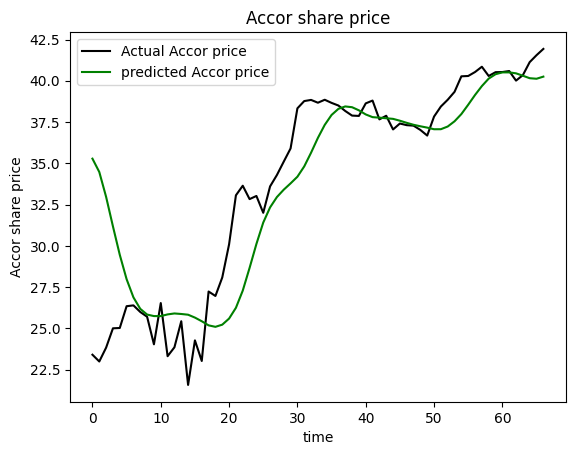

In [15]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [16]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [20]:
def draw_stock_trade(company):
    test_data = load_data(company = company,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())

    actual_prices = test_data['Close'].values

    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)
    x_test = []
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
    plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
    plt.title(f"{COMPANY} share price")
    plt.xlabel("time")
    plt.ylabel(f"{COMPANY} share price")
    plt.legend()
    plt.show()

    

3/3 [==============================] - 0s 17ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_12800\3649183426.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


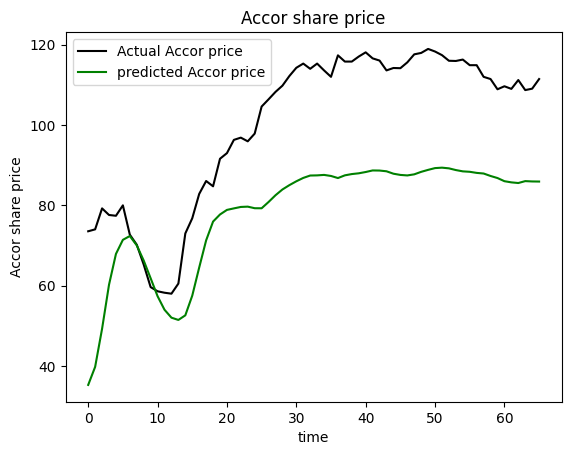

In [26]:
draw_stock_trade("Cap Gemini")